## 포르토 세구로의 운전자 생존예측

### 목차
* Imbalanced Datasets
* The metric trap
* Confusion Matrix
* Resampling
* Random under-sampling
* Random over-sampling
* Python imbalanced-learn module
* Random under-sampling and over-sampling with imbalanced-learn
* Under-Sampling : Tomek links
* Under-Sampling : Cluster Centroids
* Over-Sampling : SMOTE
* Over-Sampling followed by under-sampling
* Recommended Reading

### Imbalanced Datasets
* Resampling에 중점을 두고, Highly Unbalanced한 데이터셋을 처리하는 기술을 배울 것이다.
* 보험금 청구가 특이한 사례로 간주될 수 있기 때문에 Unbalanced Class들에 대한 classic한 문제이다.
* Unbalanced Class들의 전형적인 예로는 금융 사기의 발견과 컴퓨터 네트워크에 대한 공격이 있다.

**데이터 세트가 얼마나 Unbalanced한지 확인해 보자.**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df_train = pd.read_csv('../data/porto/train.csv')

In [3]:
df_train.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


Class 0 : 573518
Class 1 : 21694
Proportion : 26.44 : 1


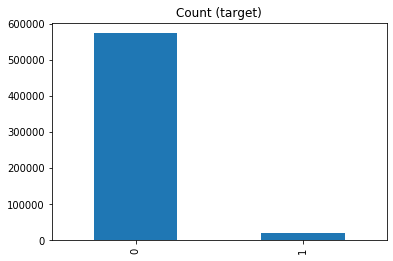

In [4]:
target_count = df_train.target.value_counts()
print('Class 0 :', target_count[0])
print('Class 1 :', target_count[1])
print('Proportion :', round(target_count[0] / target_count[1], 2), ": 1")

target_count.plot(kind = 'bar', title = 'Count (target)');

### The Metric Trap
* 불균형 데이터를 처리할 때 초보자가 겪는 주요 문제 중 하나는 모델을 평가하는 데 사용되는 메트릭과 관련이 있다.
* 불균형 데이터에서는 accuracy_score와 같은 간단한 측정 기준을 사용하는 것은 오해의 소지가 있다.
* 불균형 클래스가 있는 데이터에서 분석자가 feature에 대한 분석을 수행하지 않고 항상 가장 일반적인 클래스를 '예측'하는 경우 높은 정확더 그러나 명백한 착시율을 가질 것이다.

**feature Engineering이 아닌 단순 교차 검증을 사용하여 실험해보도록 하자**

In [5]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Remove 'id' & 'target' columns
labels = df_train.columns[2:]

X = df_train[labels]
y = df_train['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

model = XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %.2f%%' % (accuracy * 100.0))

Accuracy: 96.35%


In [6]:
model = XGBClassifier()
model.fit(X_train[['ps_calc_01']], y_train)
y_pred = model.predict(X_test[['ps_calc_01']])

accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %.2f%%' % (accuracy * 100.0))

Accuracy: 96.36%


* 높은 정확도는 환상일 뿐이었다.
* 이러한 방식때문에 Unbalanced 데이터셋에서 사용되는 메트릭 선택은 매우 중요하다.
* 여기에서 평가 메트릭은 불균형 데이터셋에 대해 보다 강력한 메트릭인 정규화된 지니계수로, 무작위 추측의 경우 약 0부터 만점의 경우 약 0.5까지 다양하다.

### Confusion Matrix
* 결과를 평가하는 흥미로운 방법은 Confusion Matrix를 통해 각 클래스에 대해 적확하고 부정확한 예측을 할 수 있도록 도와준다.

Confusion Matrix :
 [[114709      0]
 [  4334      0]]


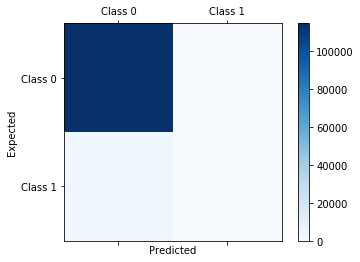

In [7]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_true = y_test, y_pred = y_pred)
print('Confusion Matrix :\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap = plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

**cax의 의미를 파악하자!!!!** 
 * heatmap에서 옆의 bar를 나타내는 것으로 추정

### Resampling
* 고도로 불균형한 데이터셋을 처리하기 위해 너릴 채택된 기술을 Resampling이라고 한다.
* Majority Class에서 표본을 제거하거나 Minority Class에서 좀 더 많은 Examples를 추가한 것으로 구성된다.
* Balancing Classes들의 이점에도 불구하고, 약점도 있다. >> 과표본의 가장 간단한 실행은 minority class들에서의 무작위 기록을 복제하는 것이다.
* Under-Sampling에서 가장 간단한 기법은 정보의 손실을 야기할 수 있는 다수 등급에서 무작위 기록을 제거하는 것을 포함한다.

**DataFrame.sample 방법을 사용하여 각 클래스의 랜덤 표본을 가져오는 기본 예제를 구현해보자**



In [8]:
count_class_0, count_class_1 = df_train.target.value_counts()

df_class_0 = df_train[df_train['target'] == 0]
df_class_1 = df_train[df_train['target'] == 1]

**Random under-sampling**
* df_class_0.sample(count_class_1)가 의미하는 바 : df_class_0에서 'count_class_1'개를 랜덤으로 샘플링한다는 것이다.

Random under-sampling
1    21694
0    21694
Name: target, dtype: int64


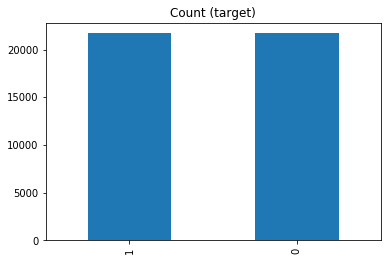

In [9]:
df_class_0_under = df_class_0.sample(count_class_1)
df_test_under = pd.concat([df_class_0_under, df_class_1], axis = 0)

print('Random under-sampling')
print(df_test_under.target.value_counts())

df_test_under.target.value_counts().plot(kind = 'bar', title = 'Count (target)')

**Random over-sampling** 

Random over-sampling:
1    573518
0    573518
Name: target, dtype: int64


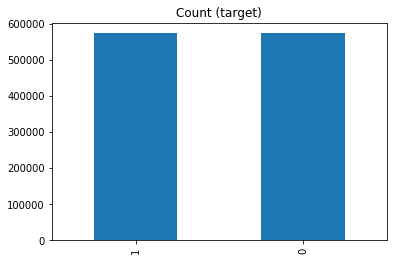

In [10]:
df_class_1_over = df_class_1.sample(count_class_0, replace = True)
df_test_over = pd.concat([df_class_0, df_class_1_over], axis = 0)

print('Random over-sampling:')
print(df_test_over.target.value_counts())

df_test_over.target.value_counts().plot(kind = 'bar', title = 'Count (target)');

### Python Imbalanced-learn Module
* 과학 문헌에는 보다 정교한 Resampling 기법이 많이 제시되어 있다.
    * 예를 들어, Majority Class의 기록을 클러스터링할 수 있다.
    * 각 클러스터에서 기록을 제거하여 정보보존을 도모함으로써 언더 샘플링을 할 수 있다.
    * Over-Sampling에서 Minority Class 기록의 정확한 사본을 만드는 대신에, 우리는 그 복사본에 작은 변형을 도입할 수 있고, 더 다양한 합성 샘플을 만들 수 있다.
    
* Python 라이브러리 불균형 학습을 사용하여 Resampling 기술을 적용해보자.
* Scikit-learn과 호환되며, Scikit-learn-contract 프로젝트의 일부분이다.

In [11]:
import imblearn

* 쉽게 시각화할 수 있도록 make_classification 방법을 사용하여 small unbalanced sample 데이터셋을 생성해보자. 

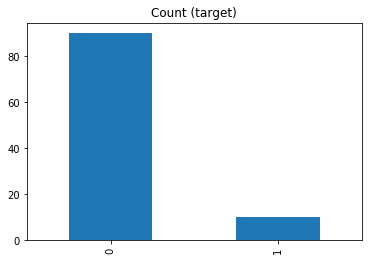

In [12]:
from sklearn.datasets import make_classification

X, y = make_classification(
        n_classes = 2, class_sep = 1.5, weights = [0.9, 0.1],
        n_informative = 3, n_redundant = 1, flip_y = 0,
        n_features = 20, n_clusters_per_class = 1,
        n_samples = 100, random_state = 10)

df = pd.DataFrame(X)
df['target'] = y
df.target.value_counts().plot(kind = 'bar', title = 'Count (target)');

* 또한, 데이터 분포를 확인하기 위해 2차원 plot함수인 plot_2d_space도 만들 것이다. 

In [13]:
def plot_2d_space(X, y, label = 'Classes') :
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    
    for l, c, m in zip(np.unique(y), colors, markers) :
        plt.scatter(X[y==l, 0], X[y==l, 1],
                    c = c, label = l, marker = m)
        
    plt.title(label)
    plt.legend(loc = 'upper right')
    plt.show()

* 데이터셋은 여러 feature들을 가지며 그래프는 2D가 되기 때문에 PCA를 사용하여 데이터셋의 크기를 줄일 것이다. 

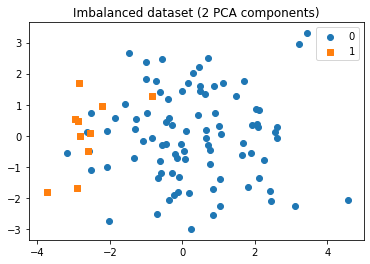

In [23]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
X = pca.fit_transform(X)

plot_2d_space(X, y, 'Imbalanced dataset (2 PCA components)')

### Random under-sampling and over-sampling with imbalanced-learn

* 아래 구문은 변경이 되어 질문결과 삭제하라고 하였음.
* 그러나 뭐가 잘못된건지 잘 모르겠음.

In [49]:
# 본문 코드
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(return_indices=True)
X_rus, y_rus, id_rus = rus.fit_sample(X, y)

print('Removed indexes:', id_rus)

plot_2d_space(X_rus, y_rus, 'Random under-sampling')

TypeError: __init__() got an unexpected keyword argument 'return_indices'

Removed indexes:


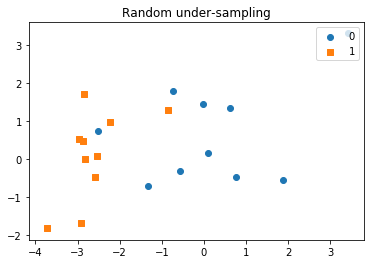

In [44]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler()
X_rus, y_rus = rus.fit_sample(X, y)

print('Removed indexes:')

plot_2d_space(X_rus, y_rus, 'Random under-sampling')

80 new random picked points


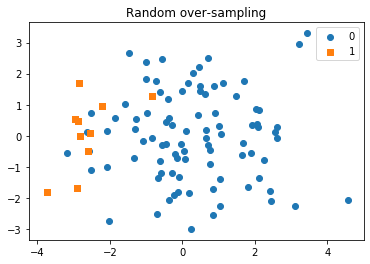

In [25]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()
X_ros, y_ros = ros.fit_sample(X, y)

print(X_ros.shape[0] - X.shape[0], 'new random picked points')

plot_2d_space(X_ros, y_ros, 'Random over-sampling')

### Under-Sampling : Tomek links

* Tomek Links는 매우 가까운 instances들의 쌍이지만, 서로 반대되는 클래스의 쌍이다.
* 각 쌍의 Majority Class의 instance를 제거하면 두 클래스 사이의 공간이 늘어나 분류 과정이 용이해진다.

**아래 코드에서, 'ratio = "majority"'를 사용하여 'majority class'를 resample한다.**

In [ ]:
# 본문 코드
from imblearn.under_sampling import TomekLinks

tl = TomekLinks(return_indices=True, ratio='majority')
X_tl, y_tl, id_tl = tl.fit_sample(X, y)

print('Removed indexes:', id_tl)

plot_2d_space(X_tl, y_tl, 'Tomek links under-sampling')

Removed indexes : 


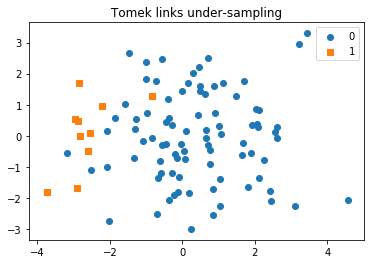

In [52]:
from imblearn.under_sampling import TomekLinks

tl = TomekLinks(sampling_strategy = 'majority')
X_tl, y_tl = tl.fit_sample(X, y)

print('Removed indexes : ')

plot_2d_space(X_tl, y_tl, 'Tomek links under-sampling')

### Under-Sampling : Cluster Centroids

* 이 기법은 군집화 방법에 따라 중심체를 생성하여 Under-sampling을 수행한다.
* 데이터는 정보를 보존하기 위해 유사성에 따라 이전에 분류된 것이다.

**다음의 예에서, 매개변수 비율에 대해 {0: 10}을 통과시켜 Majority Class(0) 그리고 모든 Minority Class(1)의 10개 요소를 보존한다.**

In [ ]:
#본문 코드
from imblearn.under_sampling import ClusterCentroids

cc = ClusterCentroids(ratio={0: 10})
X_cc, y_cc = cc.fit_sample(X, y)

plot_2d_space(X_cc, y_cc, 'Cluster Centroids under-sampling')

* 코드를 확인해본 결과 'ratio'구문이 'sampling_strategy'로 바뀌었음을 알 수 있었다. 
* But, 'return_indices'는 어떻게 바뀐지 알 수 없었다.

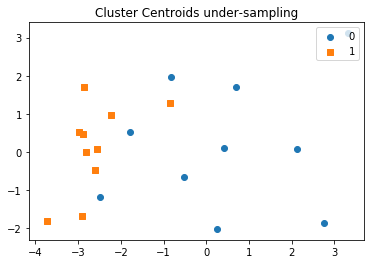

In [46]:
from imblearn.under_sampling import ClusterCentroids

cc = ClusterCentroids(sampling_strategy = {0:10})
X_cc, y_cc = cc.fit_sample(X, y)

plot_2d_space(X_cc, y_cc, 'Cluster Centroids under-sampling')

### Over-Sampling : SMOTE
* SMOTE(Synthetic Mineral Oversampling TEchnique)는 이미 존재하는 요소들을 바탕으로 Minority Class를 위한 요소들을 합성하는 것으로 구성된다.
* Minority Class로부터 한 점을 무작위로 추출하고 이 점에 대해 가장 가까운 이웃들을 계산한다.
* Synthetic Points는 선택한 포인트와 주변 포인트 사이에 추가된다.

**우리는 Minority Class를 resample하기위해 "ratio = 'minority'"구문을 사용할 것이다.**

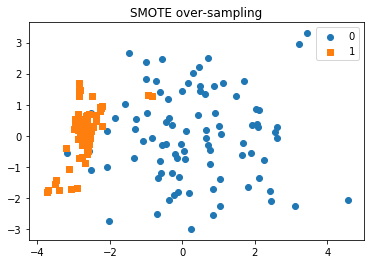

In [51]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy = 'minority')
X_sm, y_sm = smote.fit_sample(X, y)

plot_2d_space(X_sm, y_sm, 'SMOTE over-sampling')

### Over-Sampling followed by under-sampling

* 이제 SMOTE와 TomekLinks 기술을 사용하여 Over-Sampling과 Under-Sampling의 조합을 수행하겠다. 

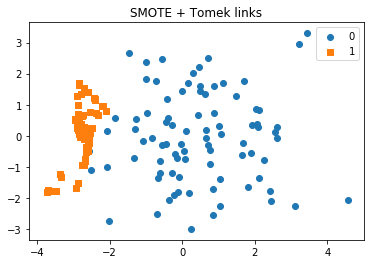

In [53]:
from imblearn.combine import SMOTETomek

smt = SMOTETomek(sampling_strategy = 'auto')
X_smt, y_smt = smt.fit_sample(X, y)

plot_2d_space(X_smt, y_smt, 'SMOTE + Tomek links')